In [ ]:
# !pip install transformers -q
!pip install tensorflow==2.1 -q

     |████████████████████████████████| 421.8MB 28kB/s 
     |████████████████████████████████| 3.9MB 54.4MB/s 
     |████████████████████████████████| 450kB 45.2MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [ ]:
#@title CyclicLR
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np

class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
import pandas as pd
data = pd.read_csv("/content/result_3.csv",encoding="iso-8859-1")

In [ ]:
data['text'] = data['text'].apply(lambda x: x.replace("\n"," ")) 

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score


def eval_acc(y_true, y_pred):
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    acc = accuracy_score(y_true, y_pred)
    return acc

def recall(y_true, y_pred):
 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
 
 
def precision(y_true, y_pred):
 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
 
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))

In [ ]:
import abc


class BaseModel(object):
    def __init__(self):
        super(BaseModel, self).__init__()

        self.model = None

    @abc.abstractmethod
    def build(self):
        """Build the model"""

    @abc.abstractmethod
    def train(self, data_train, data_dev):
        """Train the model"""

    @abc.abstractmethod
    def load_weights(self, filename):
        """Load weights from the `filename`"""

    @abc.abstractmethod
    def evaluate(self, data):
        """Evaluate the model on the provided data"""

    @abc.abstractmethod
    def predict(self, data):
        """Predict for the provided data"""

In [ ]:
data

,Unnamed: 0,ID,Primary,text,clean_text
0,0,2.024274e+08,0,Many people have different idea #3DPrinting du...,many people different idea time coronavirus li...
1,1,2.032557e+08,0,Enniente...\nA me \u2018sto #coronavirus fa an...,enniente na coronavirus fa ancora paura nquind...
2,2,2.160349e+08,0,"People, there are gonna be more of these fiasc...",people gon na fiascos coming month election un...
3,3,2.603767e+08,0,Guidelines for your journey. \nhttps://t.co/1F...,guideline journeyn coronavirus transpo travel ...
4,4,2.780104e+08,0,If only these poor people in #Tulsa understood...,poor people tulsa understood danger coronaviru...
...,...,...,...,...,...
1995,1995,1.224120e+18,1,"@cnnbrk 2019 novel coronavirus, the biological...",cnn break news novel coronavirus biological we...
1996,1996,1.223800e+18,1,RT @flyer4life: Robert Steele: China Coronavir...,robe steele china coronavirus update biowar b...
1997,1997,1.223940e+18,1,"Siri, Wuhan is home to China's first 5G instal...",siri wuhan home china first installation infec...
1998,1998,1.223760e+18,1,@smashleyhamer So what I hear you say is that ...,smashleyhamer hear say research use kill coron...


In [ ]:
#@title CONFIG -- Changes Here
class Config(object):
    def __init__(self):
        # input configuration
        self.input_level = 'word'
        self.word_max_len = 128
        self.char_max_len = 200
        self.max_len = {'word': self.word_max_len,
                        'char': self.char_max_len
                        }
        self.han_max_sent = 10
        self.word_embed_dim = 300
        self.word_embed_type = 'glove'
        self.word_embed_trainable = False
        self.word_embeddings = None

        # model structure configuration
        self.exp_name = None
        self.model_name = None
        self.rnn_units = 300
        self.dense_units = 512

        # model training configuration
        self.batch_size = 128
        self.n_epoch = 10
        self.learning_rate = 0.001
        self.optimizer = Adam(self.learning_rate)
        self.dropout = 0.5
        self.l2_reg = 0.001

        # output configuration
        self.n_class = 4

        # checkpoint configuration
        self.checkpoint_dir = 'ckpt'
        self.checkpoint_monitor = 'val_loss'
        self.checkpoint_save_best_only = True
        self.checkpoint_save_weights_only = True
        self.checkpoint_verbose = 1

        # early_stopping configuration
        self.early_stopping_monitor = 'val_loss'
        self.early_stopping_patience = 5
        self.early_stopping_verbose = 1

In [ ]:
import os
import abc
import logging

class KerasBaseModel(BaseModel):
    def __init__(self, config, **kwargs):
        super(KerasBaseModel, self).__init__()
        self.config = config
        self.level = self.config.input_level
        self.max_len = self.config.max_len[self.config.input_level]
        self.word_embeddings = config.word_embeddings
        self.n_class = config.n_class

        self.callbacks = []
        self.init_callbacks()

        self.model = self.build(**kwargs)

    def init_callbacks(self):
        self.callbacks.append(ModelCheckpoint(
            filepath=self.config.checkpoint_dir,
            monitor=self.config.checkpoint_monitor,
            save_best_only=self.config.checkpoint_save_best_only,
            save_weights_only=self.config.checkpoint_save_weights_only,
            verbose=self.config.checkpoint_verbose
        ))

        self.callbacks.append(EarlyStopping(
            monitor=self.config.early_stopping_monitor,
            patience=self.config.early_stopping_patience,
            verbose=self.config.early_stopping_verbose
        ))
        self.callbacks.append(CyclicLR())
    def load_weights(self, filename):
        self.model.load_weights(filename)

    def load_best_model(self):
        logging.info('loading model checkpoint: %s.hdf5\n' % self.config.exp_name)
        self.load_weights(os.path.join(self.config.checkpoint_dir, '%s.hdf5' % self.config.exp_name))
        logging.info('Model loaded')

    @abc.abstractmethod
    def build(self):
        """Build the model"""

    def train(self, data_train, data_dev=None):
        x_train, y_train = data_train

        logging.info('start training...')
        self.model.fit(x=x_train, y=y_train, batch_size=self.config.batch_size, epochs=self.config.n_epoch,
                       validation_data=data_dev, callbacks=self.callbacks)
        logging.info('training end...')

    def evaluate(self, data):
        input_data, label = data
        prediction = self.predict(input_data)
        acc = eval_acc(label, prediction)
        logging.info('acc : %f', acc)
        return acc

    def predict(self, data):
        return self.model.predict(data)

In [ ]:
class BiLSTM(KerasBaseModel):
    def __init__(self, config, **kwargs):
        super(BiLSTM, self).__init__(config, **kwargs)

    def build(self):
        input_text = Input(shape=(self.max_len,),dtype='int64')

        embedding_layer = Embedding(self.word_embeddings.shape[0], self.word_embeddings.shape[1],
                                    weights=[self.word_embeddings],
                                    trainable=self.config.word_embed_trainable, mask_zero=True)(input_text)
        text_embed = SpatialDropout1D(0.2)(embedding_layer)

        hidden_states = Bidirectional(LSTM(units=self.config.rnn_units, return_sequences=True))(text_embed)
        global_max_pooling = Lambda(lambda x: K.max(x, axis=1))  # GlobalMaxPooling1D didn't support masking
        sentence_embed = global_max_pooling(hidden_states)

        dense_layer = Dense(256, activation='relu')(sentence_embed)
        output = Dense(self.n_class, activation='softmax')(dense_layer)

        model = Model(input_text, output)
        model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=self.config.optimizer)
        return model

In [ ]:
# import pandas as pd
# import numpy as np
# from tensorflow.keras.utils import to_categorical
# data = pd.read_csv(r'https://query.data.world/s/nxbqt3li4mjjlsqxr77c4l7odqzdot',encoding = 'latin-1')
# data.drop(columns=['_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'choose_one:confidence', 'keyword', 'location', 'tweetid', 'userid'],inplace=True)
# data.drop(index=data[data['choose_one']=="Can't Decide"].index,columns=['choose_one_gold'],inplace=True)
# data['choose_one'].value_counts()

Not Relevant    6187
Relevant        4673
Name: choose_one, dtype: int64

In [ ]:

import re
import string
def clean(tweet):
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
  # re.sub(r"humanconsumption", "human consumption", tweet)
  #   tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
  #   tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
  #   tweet = re.sub(r"facialabuse", "facial abuse", tweet)
  #   tweet = re.sub(r"LakeCounty", "Lake County", tweet)
  #   tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
  #   tweet = re.sub(r"withheavenly", "with heavenly", tweet)
  #   tweet = re.sub(r"thankU", "thank you", tweet)
  #   tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
  #   tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
  #   tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
  #   tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
  #   tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
  #   tweet = re.sub(r"animalrescue", "animal rescue", tweet)
  #   tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
  #   tweet = re.sub(r"aRmageddon", "armageddon", tweet)
  #   tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
  #   tweet = re.sub(r"GodsLove", "God's Love", tweet)
  #   tweet = re.sub(r"bookboost", "book boost", tweet)
  #   tweet = re.sub(r"ibooklove", "I book love", tweet)
  #   tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
  #   tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
  #   tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
  #   tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
  #   tweet = re.sub(r"weathernetwork", "weather network", tweet)
  #   tweet = re.sub(r"withBioterrorism  # Hashtags and usernames
  #   tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
  #   tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
  #   tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
  #   tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
  #   tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
  #   tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
  #   tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
  #   tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
  #   tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
  #   tweet = re.sub(r"socialnews", "social news", tweet)
  #   tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
  #   tweet = re.sub(r"onlinecommunities", "online communities", tweet)
  #   tweet = &use", "with Bioterrorism & use", tweet)
  #   tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
  #   tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
  #   tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
  #   tweet = re.sub(r"frontpage", "front page", tweet)
  #   tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
  #   tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
  #   tweet = re.sub(r"til_now", "until now", tweet)
  #   tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
  #   tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
  #   tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
  #   tweet = re.sub(r"53inch", "53 inch", tweet)
  #   tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
  #   tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
  #   tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
  #   tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
  #   tweet = re.sub(r"DETECTADO", "Detected", tweet)
  #   tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
  #   tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
  #   tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
  #   tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
  #   tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
  #   tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
  #   tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
  #   tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
  #   tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
  #   tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
  #   tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
  #   tweet = re.sub(r"Time2015", "Time 2015", tweet)
  #   tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
  #   tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
  #   tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
  #   tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
  #   tweet = re.sub(r"bbcnews", "bbc news", tweet)
  #   tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
  #   tweet = re.sub(r"c4news", "c4 news", tweet)
  #   tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
  #   tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
  #   tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
  #   tweet = re.sub(r"NotExplained", "Not Explained", tweet)
  #   tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
  #   tweet = re.sub(r"LondonFire", "London Fire", tweet)
  #   tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
  #   tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
  #   tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
  #   tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
  #   tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
  #   tweet = re.sub(r"nikeplus", "nike plus", tweet)
  #   tweet = re.sub(r"david_cameron", "David Cameron", tweet)
  #   tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
  #   tweet = re.sub(r"JamesMelville", "James Melville", tweet)
  #   tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
  #   tweet = re.sub(r"cnewslive", "C News Live", tweet)
  #   tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
  #   tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
  #   tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
  #   tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
  #   tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
  #   tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
  #   tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
  #   tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
  #   tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
  #   tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
  #   tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
  #   tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
  #   tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
  #   tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
  #   tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
  #   tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
  #   tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
  #   tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
  #   tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
  #   tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
  #   tweet = re.sub(r"GRupdates", "GR updates", tweet)
  #   tweet = re.sub(r"SouthDowns", "South Downs", tweet)
  #   tweet = re.sub(r"braininjury", "brain injury", tweet)
  #   tweet = re.sub(r"auspol", "Australian politics", tweet)
  #   tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
  #   tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
  #   tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
  #   tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
  #   tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
  #   tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
  #   tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
  #   tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
  #   tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
  #   tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
  #   tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
  #   tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
  #   tweet = re.sub(r"offers2go", "offers to go", tweet)
  #   tweet = re.sub(r"foodscare", "food scare", tweet)
  #   tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
  #   tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
  #   tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
  #   tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
  #   tweet = re.sub(r"spinningbot", "spinning bot", tweet)
  #   tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
  #   tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
  #   tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
  #   tweet = re.sub(r"po_st", "po.st", tweet)
  #   tweet = re.sub(r"scoopit", "scoop.it", tweet)
  #   tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
  #   tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
  #   tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
  #   tweet = re.sub(r"rapidcity", "Rapid City", tweet)
  #   tweet = re.sub(r"OutBid", "outbid", tweet)
  #   tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
  #   tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
  #   tweet = re.sub(r"15PM", "15 PM", tweet)
  #   tweet = re.sub(r"OriginalFunko", "Funko", tweet)
  #   tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
  #   tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
  #   tweet = re.sub(r"RT_America", "RT America", tweet)
  #   tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
  #   tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
  #   tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
  #   tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
  #   tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
  #   tweet = re.sub(r"gunsense", "gun sense", tweet)
  #   tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
  #   tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
  #   tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
  #   tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
  #   tweet = re.sub(r"renew911health", "renew 911 health", tweet)
  #   tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
  #   tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
  #   tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
  #   tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
  #   tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
  #   tweet = re.sub(r"pdx911", "Portland Police", tweet)
  #   tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
  #   tweet = re.sub(r"Japton", "Arkansas", tweet)
  #   tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
  #   tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
  #   tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
  #   tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
  #   tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
  #   tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
  #   tweet = re.sub(r"versethe", "verse the", tweet)
  #   tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
  #   tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
  #   tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
  #   tweet = re.sub(r"NANKANA", "Nankana", tweet)
  #   tweet = re.sub(r"SAHIB", "Sahib", tweet)
  #   tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
  #   tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
  #   tweet = re.sub(r"gofundme", "go fund me", tweet)
  #   tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
  #   tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
  #   tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
  #   tweet = re.sub(r"bancodeseries", "banco de series", tweet)
  #   tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
  #   tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
  #   tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
  #   tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
  #   tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
  #   tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
  #   tweet = re.sub(r"Kowing", "Knowing", tweet)
  #   tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
  #   tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
  #   tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
  #   tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
  #   tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
  #   tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
  #   tweet = re.sub(r"Ptbo", "Peterborough", tweet)
  #   tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
  #   tweet = re.sub(r"IndianNews", "Indian News", tweet)
  #   tweet = re.sub(r"savebees", "save bees", tweet)
  #   tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
  #   tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
  #   tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
  #   tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
  #   tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
  #   tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
  #   tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
  #   tweet = re.sub(r"Daesh", "ISIS", tweet)
  #   tweet = re.sub(r"s2g", "swear to god", tweet)
  #   tweet = re.sub(r"listenlive", "listen live", tweet)
  #   tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
  #   tweet = re.sub(r"FoxNew", "Fox News", tweet)
  #   tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
  #   tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
  #   tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
  #   tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
  #   tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
  #   tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
  #   tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
  #   tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
  #   tweet = re.sub(r"HORNDALE", "Horndale", tweet)
  #   tweet = re.sub(r"PINER", "Piner", tweet)
  #   tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
  #   tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
  #   tweet = re.sub(r"residualincome", "residual income", tweet)
  #   tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
  #   tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
  #   tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
  #   tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
  #   tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
  #   tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
  #   tweet = re.sub(r"pop2015", "pop 2015", tweet)
  #   tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
  #   tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
  #   tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
  #   tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
  #   tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
  #   tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
  #   tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
  #   tweet = re.sub(r"EndConflict", "End Conflict", tweet)
  #   tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
  #   tweet = re.sub(r"UNHEALED", "unhealed", tweet)
  #   tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
  #   tweet = re.sub(r"Latestnews", "Latest news", tweet)
  #   tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
  #   tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
  #   tweet = re.sub(r"datingtips", "dating tips", tweet)
  #   tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
  #   tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
  #   tweet = re.sub(r"txlege", "Texas Legislature", tweet)
  #   tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
  #   tweet = re.sub(r"Newss", "News", tweet)
  #   tweet = re.sub(r"hempoil", "hemp oil", tweet)
  #   tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
  #   tweet = re.sub(r"tubestrike", "tube strike", tweet)
  #   tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
  #   tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
  #   tweet = re.sub(r"TI5", "The International 5", tweet)
  #   tweet = re.sub(r"thehill", "the hill", tweet)
  #   tweet = re.sub(r"3others", "3 others", tweet)
  #   tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
  #   tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
  #   tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
  #   tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
  #   tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
  #   tweet = re.sub(r"offdishduty", "off dish duty", tweet)
  #   tweet = re.sub(r"andword", "and word", tweet)
  #   tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
  #   tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
  #   tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
  #   tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
  #   tweet = re.sub(r"57am", "57 am", tweet)
  #   tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
  #   tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
  #   tweet = re.sub(r"newnewnew", "new new new", tweet)
  #   tweet = re.sub(r"under50", "under 50", tweet)
  #   tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
  #   tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
  #   tweet = re.sub(r"amwriting", "am writing", tweet)
  #   tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
  #   tweet = re.sub(r"Nowlike", "Now like", tweet)
  #   tweet = re.sub(r"seasonfrom", "season from", tweet)
  #   tweet = re.sub(r"epicente", "epicenter", tweet)
  #   tweet = re.sub(r"epicenterr", "epicenter", tweet)
  #   tweet = re.sub(r"sicklife", "sick life", tweet)
  #   tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
  #   tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
  #   tweet = re.sub(r"approachng", "approaching", tweet)
  #   tweet = re.sub(r"evng", "evening", tweet)
  #   tweet = re.sub(r"Sumthng", "something", tweet)
  #   tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
  #   tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
  #   tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
  #   tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
  #   tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
  #   tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
  #   tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
  #   tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
  #   tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
  #   tweet = re.sub(r"TCMParty", "TCM Party", tweet)
  #   tweet = re.sub(r"marijuananews", "marijuana news", tweet)
  #   tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
  #   tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
  #   tweet = re.sub(r"newauthors", "new authors", tweet)
  #   tweet = re.sub(r"remedyyyy", "remedy", tweet)
  #   tweet = re.sub(r"44PM", "44 PM", tweet)
  #   tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
  #   tweet = re.sub(r"40PM", "40 PM", tweet)
  #   tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
  #   tweet = re.sub(r"ithats", "that is", tweet)
  #   tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
  #   tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
  #   tweet = re.sub(r"02PM", "02 PM", tweet)
  #   tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
  #   tweet = re.sub(r"Bstrd", "bastard", tweet)
  #   tweet = re.sub(r"bldy", "bloody", tweet)
  #   tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
  #   tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
  #   tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
  #   tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
  #   tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
  #   tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
  #   tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
  #   tweet = re.sub(r"incubusband", "incubus band", tweet)
  #   tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
  #   tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
  #   tweet = re.sub(r"win10", "Windows 10", tweet)
  #   tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
  #   tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
  #   tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
  #   tweet = re.sub(r"crewlist", "crew list", tweet)
  #   tweet = re.sub(r"Erdogans", "Erdogan", tweet)
  #   tweet = re.sub(r"BBCLive", "BBC Live", tweet)
  #   tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
  #   tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
  #   tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
  #   tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
  #   tweet = re.sub(r"pctool", "pc tool", tweet)
  #   tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
  #   tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
  #   tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
  #   tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
  #   tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
  #   tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
  #   tweet = re.sub(r"writerslife", "writers life", tweet)
  #   tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
  #   tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
  #   tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
  #   tweet = re.sub(r"acreativedc", "a creative DC", tweet)
  #   tweet = re.sub(r"vscodc", "vsco DC", tweet)
  #   tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
  #   tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
  #   tweet = re.sub(r"buildingmuseum", "building museum", tweet)
  #   tweet = re.sub(r"WorldOil", "World Oil", tweet)
  #   tweet = re.sub(r"redwedding", "red wedding", tweet)
  #   tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
  #   tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
  #   tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
  #   tweet = re.sub(r"bleased", "blessed", tweet)
  #   tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
  #   tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
  #   tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
  #   tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
  #   tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
  #   tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
  #   tweet = re.sub(r"dirtylying", "dirty lying", tweet)
  #   tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
  #   tweet = re.sub(r"changetheworld", "change the world", tweet)
  #   tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
  #   tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
  #   tweet = re.sub(r"withweapons", "with weapons", tweet)
  #   tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
  #   tweet = re.sub(r"letsFootball", "let us Football", tweet)
  #   tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
  #   tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
  #   tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
  #   tweet = re.sub(r"22PM", "22 PM", tweet)
  #   tweet = re.sub(r"54am", "54 AM", tweet)
  #   tweet = re.sub(r"38am", "38 AM", tweet)
  #   tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
  #   tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
  #   tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
  #   tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
  #   tweet = re.sub(r"2k15", "2015", tweet)
  #   tweet = re.sub(r"TheIran", "Iran", tweet)
  #   tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
  #   tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
  #   tweet = re.sub(r"defense_news", "defense news", tweet)
  #   tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
  #   tweet = re.sub(r"Auspol", "Australia Politics", tweet)
  #   tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
  #   tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
  #   tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
  #   tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
  #   tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
  #   tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
  #   tweet = re.sub(r"toopainful", "too painful", tweet)
  #   tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
  #   tweet = re.sub(r"NoNukes", "No Nukes", tweet)
  #   tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
  #   tweet = re.sub(r"ineedcake", "I need cake", tweet)
  #   tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
  #   tweet = re.sub(r"BBCOne", "BBC One", tweet)
  #   tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
  #   tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
  #   tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
  #   tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
  #   tweet = re.sub(r"irongiant", "iron giant", tweet)
  #   tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
  #   tweet = re.sub(r"TimCook", "Tim Cook", tweet)
  #   tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
  #   tweet = re.sub(r"Madsummer", "Mad summer", tweet)
  #   tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
  #   tweet = re.sub(r"concertphotography", "concert photography", tweet)
  #   tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
  #   tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
  #   tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
  #   tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
  #   tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
  #   tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
  #   tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
  #   tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
  #   tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
  #   tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
  #   tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
  #   tweet = re.sub(r"NotSorry", "not sorry", tweet)
  #   tweet = re.sub(r"UseYourWords", "use your words", tweet)
  #   tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
  #   tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
  #   tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
  #   tweet = re.sub(r"jokethey", "joke they", tweet)
  #   tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
  #   tweet = re.sub(r"uiseful", "useful", tweet)
  #   tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
  #   tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
  #   tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
  #   tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
  #   tweet = re.sub(r"birdgang", "bird gang", tweet)
  #   tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
  #   tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
  #   tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
  #   tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
  #   tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
  #   tweet = re.sub(r"TOI_India", "The Times of India", tweet)
  #   tweet = re.sub(r"hegot", "he got", tweet)
  #   tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
  #   tweet = re.sub(r"sothathappened", "so that happened", tweet)
  #   tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
  #   tweet = re.sub(r"NationFirst", "Nation First", tweet)
  #   tweet = re.sub(r"IndiaToday", "India Today", tweet)
  #   tweet = re.sub(r"HLPS", "helps", tweet)
  #   tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
  #   tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
  #   tweet = re.sub(r"BidTime", "Bid Time", tweet)
  #   tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
  #   tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
  #   tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
  #   tweet = re.sub(r"eatshit", "eat shit", tweet)
  #   tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
  #   tweet = re.sub(r"SahelNews", "Sahel News", tweet)
  #   tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
  #   tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
  #   tweet = re.sub(r"facilitydude", "facility dude", tweet)
  #   tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
  #   tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
  #   tweet = re.sub(r"MarketResearch", "Market Research", tweet)
  #   tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
  #   tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
  #   tweet = re.sub(r"yychail", "Calgary hail", tweet)
  #   tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
  #   tweet = re.sub(r"eliotschool", "eliot school", tweet)
  #   tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
  #   tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
  #   tweet = re.sub(r"RiverComplex", "River Complex", tweet)
  #   tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
  #   tweet = re.sub(r"IranElection", "Iran Election", tweet)
  #   tweet = re.sub(r"glowng", "glowing", tweet)
  #   tweet = re.sub(r"kindlng", "kindling", tweet)
  #   tweet = re.sub(r"riggd", "rigged", tweet)
  #   tweet = re.sub(r"slownewsday", "slow news day", tweet)
  #   tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
  #   tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
  #   tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
  #   tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
  #   tweet = re.sub(r"netbots", "net bots", tweet)
  #   tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
  #   tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
  #   tweet = re.sub(r"EndofUS", "End of United States", tweet)
  #   tweet = re.sub(r"35PM", "35 PM", tweet)
  #   tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
  #   tweet = re.sub(r"76mins", "76 minutes", tweet)
  #   tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
  #   tweet = re.sub(r"livesmatter", "lives matter", tweet)
  #   tweet = re.sub(r"myhometown", "my hometown", tweet)
  #   tweet = re.sub(r"tankerfire", "tanker fire", tweet)
  #   tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
  #   tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
  #   tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
  #   tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
  #   tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
  #   tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
  #   tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
  #   tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
  #   tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
  #   tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
  #   tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
  #   tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
  #   tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
  #   tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
  #   tweet = re.sub(r"kostumes", "costumes", tweet)
  #   tweet = re.sub(r"YEEESSSS", "yes", tweet)
  #   tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
  #   tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
  #   tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
  #   tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
  #   tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
  #   tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
  #   tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
  #   tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
  #   tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
  #   tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
  #   tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
  #   tweet = re.sub(r"FromTheField", "From the field", tweet)
  #   tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
  #   tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
  #   tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
  #   tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
  #   tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
  #   tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
  #   tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
  #   tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
  #   tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
  #   tweet = re.sub(r"Evaucation", "evacuation", tweet)
  #   tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
  #   tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
  #   tweet = re.sub(r"Tubestrike", "tube strike", tweet)
  #   tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
  #   tweet = re.sub(r"localplumber", "local plumber", tweet)
  #   tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
  #   tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
  #   tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
  #   tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
  #   tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
  #   tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
  #   tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
  #   tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
  #   tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
  #   tweet = re.sub(r"wfocus", "focus", tweet)
  #   tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
  #   tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
  #   tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
  #   tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
  #   tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
  #   tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
  #   tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
  #   tweet = re.sub(r"bedhair", "bed hair", tweet)
  #   tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
  #   tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        
    # # Acronyms
    # tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    # tweet = re.sub(r"mÌ¼sica", "music", tweet)
    # tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    # tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    # tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    # tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    # tweet = re.sub(r"cawx", "California Weather", tweet)
    # tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    # tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    # tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    # tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    # tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    # tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)

    tweet = re.sub(r'https?://\S+|www\.\S+',r'',tweet)
    tweet = re.sub(r'<.*?>',r'',tweet)
    tweet = re.sub("["
                    u"\U0001F600-\U0001F64F"  # emoticons
                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    "]+",r'', tweet, flags=re.UNICODE)
    table=str.maketrans('','',string.punctuation)
    return tweet.translate(table).lower()

In [ ]:
data['clean_text'] = data['text'].apply(lambda x: clean(x))

In [ ]:
import regex as re
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
import regex as re

# Data Pre-processing - This will help in getting better results.
data['clean_text'] = [re.sub(r'/&lt;br&gt;/', '', entry) for entry in data['clean_text']]
data['clean_text'] = [re.sub(r'-', ' ', entry) for entry in data['clean_text']]
# Remove blank rows if any.
data['clean_text'].dropna(inplace=True)

# Change all the text_cleaned to lower case. This is required as python interprets 'dog' and 'DOG' differently
data['clean_text'] = [entry.lower() for entry in data['clean_text']]

# Remove URLs
data['clean_text'] = [re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', entry) for entry in data['clean_text']]
data['clean_text'] = [re.sub(r'http\S+', '', entry) for entry in data['clean_text']]

#Remove Stop words
# # Remove regular english words like am, is, are and ...
# stop = stopwords.words('english')
# pat = r'\b(?:{})\b'.format('|'.join(stop))
# data['clean_text'] = data['clean_text'].str.replace(pat, '')
# data['clean_text'] = data['clean_text'].str.replace(r'\s+', ' ')

#Remove non alphanumeric characters and combination of alphabet and numbers-(Example- gyj132)
data['clean_text'] = [re.sub(r'[^a-zA-Z0-9 .]', '', entry) for entry in data['clean_text']]

data['clean_text'] = [re.sub(r'\w*[0-9]\w*', '', entry) for entry in data['clean_text']]

#Remove single alpha
data['clean_text'] = [re.sub(r'(^| ).( |$)', '', entry) for entry in data['clean_text']]

data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,ID,Primary,text,Unnamed: 3,clean_text
0,2.024274e+08,0,Many people have different idea #3DPrinting du...,NaN,many people have different idea during times o...
1,2.032557e+08,0,Enniente...\nA me \u2018sto #coronavirus fa an...,NaN,ennientena me coronavirus fa ancora paura nqui...
2,2.160349e+08,0,"People, there are gonna be more of these fiasc...",NaN,people there are gonna be more of these fiasco...
3,2.603767e+08,0,Guidelines for your journey. \nhttps://t.co/1F...,NaN,guidelines for your journeyn coronavirustransp...
4,2.780104e+08,0,If only these poor people in #Tulsa understood...,NaN,if only these poor people intulsa understood t...
...,...,...,...,...,...
1995,1.224120e+18,1,"@cnnbrk 2019 novel coronavirus, the biological...",NaN,cnn breaking news novel coronavirus the biolo...
1996,1.223800e+18,1,RT @flyer4life: Robert Steele: China Coronavir...,NaN,rtrobert steelechina coronavirusupdatebiowar b...
1997,1.223940e+18,1,"Siri, Wuhan is home to China's first 5G instal...",NaN,siri wuhan is home to china first installatio...
1998,1.223760e+18,1,@smashleyhamer So what I hear you say is that ...,NaN,smashleyhamer so whathear you say is that rese...


In [ ]:
data

,ID,Primary,text,Unnamed: 3,clean_text
0,2.024274e+08,0,Many people have different idea #3DPrinting du...,NaN,many people have different idea 3dprinting d...
1,2.032557e+08,0,Enniente...\nA me \u2018sto #coronavirus fa an...,NaN,enniente na me u2018sto coronavirus fa ...
2,2.160349e+08,0,"People, there are gonna be more of these fiasc...",NaN,people there are gonna be more of these fiasco...
3,2.603767e+08,0,Guidelines for your journey. \nhttps://t.co/1F...,NaN,guidelines for your journey n n coronavirus...
4,2.780104e+08,0,If only these poor people in #Tulsa understood...,NaN,if only these poor people in tulsa understoo...
...,...,...,...,...,...
1995,1.224120e+18,1,"@cnnbrk 2019 novel coronavirus, the biological...",NaN,cnn breaking news 2019 novel coronavirus the...
1996,1.223800e+18,1,RT @flyer4life: Robert Steele: China Coronavir...,NaN,rt flyer4life robert steele china corona...
1997,1.223940e+18,1,"Siri, Wuhan is home to China's first 5G instal...",NaN,siri wuhan is home to china s first 5g instal...
1998,1.223760e+18,1,@smashleyhamer So what I hear you say is that ...,NaN,smashleyhamer so what i hear you say is that...


In [ ]:
data.to_csv("/content/kath_tran_2.csv")

In [ ]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn

In [ ]:
# Tokenization : In this each entry in the corpus will be broken into set of words
data['clean_text']= [word_tokenize(entry) for entry in data['clean_text']]


In [ ]:
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [ ]:
for index,entry in enumerate(data['clean_text']):
    word_Lemmatized = WordNetLemmatizer()
    Final_words = []
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
      word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
      word_Final = word_Final.replace("..", "")
      word_Final = word_Final.replace("rt", "")
      Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    text = " ".join(Final_words)
    data.loc[index, 'clean_text'] = str(text)
    data['clean_text'].dropna(inplace=True)

In [ ]:
data.to_csv("/content/kath_cl_final.csv")

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

In [ ]:
data.head()

,Unnamed: 0,ID,Primary,text,clean_text
0,0,202427371.0,0,Many people have different idea #3DPrinting du...,many people different idea time coronavirus li...
1,1,203255669.0,0,Enniente...\nA me \u2018sto #coronavirus fa an...,enniente na coronavirus fa ancora paura nquind...
2,2,216034890.0,0,"People, there are gonna be more of these fiasc...",people gon na fiascos coming month election un...
3,3,260376727.0,0,Guidelines for your journey. \nhttps://t.co/1F...,guideline journeyn coronavirus transpo travel ...
4,4,278010380.0,0,If only these poor people in #Tulsa understood...,poor people tulsa understood danger coronaviru...


In [ ]:
data['Primary'].value_counts()

0    768
1    466
2    464
3    302
Name: Primary, dtype: int64

In [ ]:
from tqdm import tqdm
l = []
for text in tqdm(data['clean_text']):
  text = str(text)
  l = l + text.split()

100%|██████████| 2000/2000 [00:00<00:00, 18343.93it/s]


In [ ]:
len(list(set(l)))

6640

In [ ]:
data['clean_text'] = data['clean_text'].apply(lambda x: str(x))

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 128
MAX_NB_WORDS = len(list(set(l)))
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['clean_text'].values)
sequences = tokenizer.texts_to_sequences(data['clean_text'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

pad_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 6640 unique tokens.


In [ ]:
pad_text

array([[   0,    0,    0, ...,  470, 1291, 2774],
       [   0,    0,    0, ..., 2793,  471, 2794],
       [   0,    0,    0, ..., 2797,  103,  385],
       ...,
       [   0,    0,    0, ...,  349,   82, 6638],
       [   0,    0,    0, ...,   14,    1,   14],
       [   0,    0,    0, ...,  554,  363,    4]], dtype=int32)

In [ ]:
!pip install --upgrade kaggle -q
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d takuok/glove840b300dtxt
!unzip /content/glove840b300dtxt.zip
!rm /content/glove840b300dtxt.zip
!rm kaggle.json

Saving kaggle.json to kaggle.json
100% 2.07G/2.08G [00:26<00:00, 94.5MB/s]
100% 2.08G/2.08G [00:26<00:00, 85.2MB/s]
Archive:  /content/glove840b300dtxt.zip
  inflating: glove.840B.300d.txt     


In [ ]:
embeddings_index = {}
f = open('/content/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()
!rm /content/glove.840B.300d.txt
print('\nFound %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Found %s word vectors.' % len(embedding_matrix))
del embedding_vector,embeddings_index

2196018it [03:02, 12008.32it/s]



Found 2196017 word vectors.
Found 6641 word vectors.


In [ ]:
pad_text

array([[   0,    0,    0, ...,  470, 1291, 2774],
       [   0,    0,    0, ..., 2793,  471, 2794],
       [   0,    0,    0, ..., 2797,  103,  385],
       ...,
       [   0,    0,    0, ...,  349,   82, 6638],
       [   0,    0,    0, ...,   14,    1,   14],
       [   0,    0,    0, ...,  554,  363,    4]], dtype=int32)

In [ ]:
data.head(10)

,Unnamed: 0,ID,Primary,text,clean_text
0,0,202427371.0,0,Many people have different idea #3DPrinting du...,many people different idea time coronavirus li...
1,1,203255669.0,0,Enniente...\nA me \u2018sto #coronavirus fa an...,enniente na coronavirus fa ancora paura nquind...
2,2,216034890.0,0,"People, there are gonna be more of these fiasc...",people gon na fiascos coming month election un...
3,3,260376727.0,0,Guidelines for your journey. \nhttps://t.co/1F...,guideline journeyn coronavirus transpo travel ...
4,4,278010380.0,0,If only these poor people in #Tulsa understood...,poor people tulsa understood danger coronaviru...
5,5,286759324.0,0,Excellent analysis. Worth reading - #Coronavir...,excellent analysis woh read coronavirus uk dea...
6,6,307747405.0,0,KUNG FLU!!! You morons! Also- go fys #ChinaVirus,kung flu moron also go fys chinavirus
7,7,323442821.0,0,Every talk show on television Has become \nWay...,every talk show television become nwayne world...
8,8,335249599.0,0,"Is it me, or did Trump call #CoronaVirus \u201...",trump call coronavirushear right trumprallytul...
9,9,340905223.0,0,Because.....IT IS!!!!!!!!!!!! #ChineseVirus #K...,chinesevirus kungflu wuhanflu


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
X_train,X_test, y_train, y_test = train_test_split(pad_text,data['Primary'].values, test_size=0.2,shuffle=True,random_state=124, stratify=data['Primary'])
y_train = to_categorical(y_train,num_classes=4)
y_test = to_categorical(y_test,num_classes=4)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Dense, LSTM, Bidirectional, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
#@title BILSTM Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Dense, LSTM, Bidirectional, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

input_text = Input(shape=(128,),dtype='int64')

embedding_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False, mask_zero=True)(input_text)
text_embed = SpatialDropout1D(0.4)(embedding_layer)

hidden_states = Bidirectional(LSTM(units=300, return_sequences=True))(text_embed)
global_max_pooling = Lambda(lambda x: K.max(x, axis=1))  # GlobalMaxPooling1D didn't support masking
sentence_embed = global_max_pooling(hidden_states)

dense_layer = Dense(256, activation='relu')(sentence_embed)
output = Dense(4, activation='softmax')(dense_layer)

BiLSTM = Model(input_text, output)
BiLSTM.compile(loss='categorical_crossentropy', metrics=(['accuracy',precision,recall,f1]), optimizer=Adam(0.001))
model_ckpt = ModelCheckpoint(
            filepath="/content/BiLSTM/cp.ckpt",
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            verbose = 1)
early_stop = EarlyStopping(
            monitor='loss',
            mode='max',
            patience=5,
            verbose = 1
        )
lr_callback = CyclicLR()
history = BiLSTM.fit(X_train,y_train, batch_size=128, epochs=10,
                       validation_data=(X_test,y_test), callbacks=[model_ckpt,early_stop,lr_callback])

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 1.1126 - accuracy: 0.5344 - precision: 0.6074 - recall: 0.2043 - f1: nan
Epoch 00001: val_loss improved from inf to 0.82741, saving model to /content/BiLSTM/cp.ckpt
13/13 [==============================] - 9s 667ms/step - loss: 1.1126 - accuracy: 0.5344 - precision: 0.6074 - recall: 0.2043 - f1: nan - val_loss: 0.8274 - val_accuracy: 0.6775 - val_precision: 0.7407 - val_recall: 0.4551 - val_f1: 0.5621
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 0.7562 - accuracy: 0.7013 - precision: 0.7557 - recall: 0.5944 - f1: 0.6638
Epoch 00002: val_loss improved from 0.82741 to 0.69849, saving model to /content/BiLSTM/cp.ckpt
13/13 [==============================] - 7s 523ms/step - loss: 0.7562 - accuracy: 0.7013 - precision: 0.7557 - recall: 0.5944 - f1: 0.6638 - val_loss: 0.6985 - val_accuracy: 0.6900 - val_precision: 0.7018 - val_recall: 0.6074 - val_f1: 0.6509
Epoch 3/10
13/13 [==========================

In [ ]:
#@title BILSTM Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Dense, LSTM, Bidirectional, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

input_text = Input(shape=(128,),dtype='int64')

embedding_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False, mask_zero=True)(input_text)
text_embed = SpatialDropout1D(0.4)(embedding_layer)

hidden_states = Bidirectional(LSTM(units=300, return_sequences=True))(text_embed)
global_max_pooling = Lambda(lambda x: K.max(x, axis=1))  # GlobalMaxPooling1D didn't support masking
sentence_embed = global_max_pooling(hidden_states)

dense_layer = Dense(256, activation='relu')(sentence_embed)
dense_layer = Dense(128, activation='relu')(dense_layer)
dense_layer = Dense(64, activation='relu')(dense_layer)
output = Dense(4, activation='softmax')(dense_layer)

BiLSTM = Model(input_text, output)
BiLSTM.compile(loss='categorical_crossentropy', metrics=(['accuracy',precision,recall,f1]), optimizer=Adam(0.001))
model_ckpt = ModelCheckpoint(
            filepath="/content/BiLSTM/cp.ckpt",
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            verbose = 1)
early_stop = EarlyStopping(
            monitor='loss',
            mode='max',
            patience=5,
            verbose = 1
        )
lr_callback = CyclicLR()
history = BiLSTM.fit(X_train,y_train, batch_size=32, epochs=10,
                       validation_data=(X_test,y_test), callbacks=[model_ckpt,early_stop,lr_callback])

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 1.0245 - accuracy: 0.5600 - precision: 0.5439 - recall: 0.3212 - f1: nan
Epoch 00001: val_loss improved from inf to 0.77482, saving model to /content/BiLSTM/cp.ckpt
50/50 [==============================] - 14s 277ms/step - loss: 1.0245 - accuracy: 0.5600 - precision: 0.5439 - recall: 0.3212 - f1: nan - val_loss: 0.7748 - val_accuracy: 0.6800 - val_precision: 0.7379 - val_recall: 0.5457 - val_f1: 0.6258
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.7312 - precision: 0.7737 - recall: 0.6250 - f1: 0.6905
Epoch 00002: val_loss improved from 0.77482 to 0.70877, saving model to /content/BiLSTM/cp.ckpt
50/50 [==============================] - 12s 240ms/step - loss: 0.7195 - accuracy: 0.7312 - precision: 0.7737 - recall: 0.6250 - f1: 0.6905 - val_loss: 0.7088 - val_accuracy: 0.7075 - val_precision: 0.7527 - val_recall: 0.6322 - val_f1: 0.6861
Epoch 3/10
50/50 [========================

In [ ]:
#@title BILSTM Model-cln
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Dense, LSTM, Bidirectional, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

input_text = Input(shape=(128,),dtype='int64')

embedding_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False, mask_zero=True)(input_text)
text_embed = SpatialDropout1D(0.4)(embedding_layer)

hidden_states = Bidirectional(LSTM(units=300, return_sequences=True))(text_embed)
global_max_pooling = Lambda(lambda x: K.max(x, axis=1))  # GlobalMaxPooling1D didn't support masking
sentence_embed = global_max_pooling(hidden_states)

dense_layer = Dense(256, activation='relu')(sentence_embed)
output = Dense(4, activation='softmax')(dense_layer)

BiLSTM = Model(input_text, output)
BiLSTM.compile(loss='categorical_crossentropy',  metrics=(['accuracy',precision,recall,f1]), optimizer=Adam(0.001))
model_ckpt = ModelCheckpoint(
            filepath="/content/BiLSTM/cp.ckpt",
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            verbose = 1)
early_stop = EarlyStopping(
            monitor='loss',
            mode='max',
            patience=5,
            verbose = 1
        )
lr_callback = CyclicLR()
history = BiLSTM.fit(X_train,y_train, batch_size=128, epochs=10,
                       validation_data=(X_test,y_test), callbacks=[model_ckpt,early_stop,lr_callback])

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 1.0727 - accuracy: 0.5606 - precision: 0.5347 - recall: 0.2097 - f1: nan
Epoch 00001: val_loss improved from inf to 0.84075, saving model to /content/BiLSTM/cp.ckpt
13/13 [==============================] - 9s 676ms/step - loss: 1.0727 - accuracy: 0.5606 - precision: 0.5347 - recall: 0.2097 - f1: nan - val_loss: 0.8408 - val_accuracy: 0.6475 - val_precision: 0.6320 - val_recall: 0.5449 - val_f1: 0.5850
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 0.7645 - accuracy: 0.7013 - precision: 0.7366 - recall: 0.6112 - f1: 0.6677
Epoch 00002: val_loss improved from 0.84075 to 0.72902, saving model to /content/BiLSTM/cp.ckpt
13/13 [==============================] - 7s 524ms/step - loss: 0.7645 - accuracy: 0.7013 - precision: 0.7366 - recall: 0.6112 - f1: 0.6677 - val_loss: 0.7290 - val_accuracy: 0.7275 - val_precision: 0.7591 - val_recall: 0.5918 - val_f1: 0.6645
Epoch 3/10
13/13 [==========================

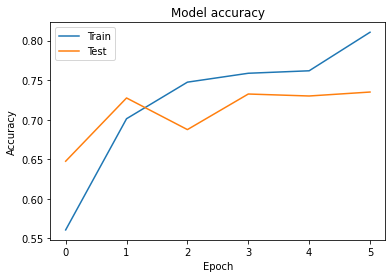

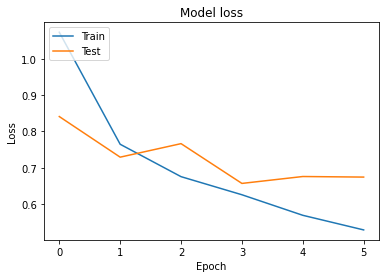

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

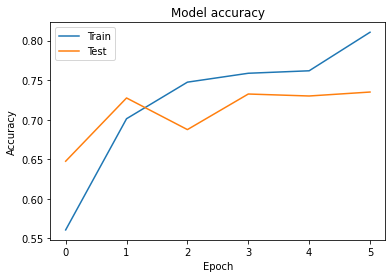

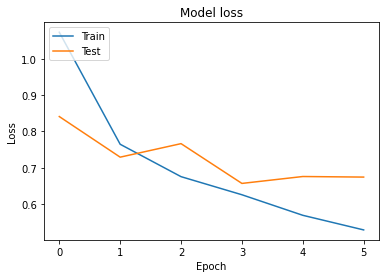

In [ ]:
import matplotlib.pyplot as plt
#clean
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#@title TEXTCNN
from keras.models import Model
from keras.layers import Input, Embedding, SpatialDropout1D, Conv1D, MaxPool1D, Flatten, concatenate, Dense
# from models.keras_base_model import KerasBaseModel
class TextCNN(KerasBaseModel):
def __init__(self, config, **kwargs):
super(TextCNN, self).__init__(config, **kwargs)
def build(self):
input_text = Input(shape=(self.max_len,))
embedding_layer = Embedding(self.word_embeddings.shape[0], self.word_embeddings.shape[1],
weights=[self.word_embeddings],
trainable=self.config.word_embed_trainable)(input_text)
text_embed = SpatialDropout1D(0.2)(embedding_layer)
filter_lengths = [2, 3, 4, 5]
conv_layers = []
for filter_length in filter_lengths:
conv_layer = Conv1D(filters=300, kernel_size=filter_length, padding='valid',
strides=1, activation='relu')(text_embed)
maxpooling = MaxPool1D(pool_size=self.max_len - filter_length + 1)(conv_layer)
flatten = Flatten()(maxpooling)
conv_layers.append(flatten)
sentence_embed = concatenate(inputs=conv_layers)
dense_layer = Dense(256, activation='relu')(sentence_embed)
output = Dense(self.n_class, activation='softmax')(dense_layer)
model = Model(input_text, output)
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=self.config.optimizer)
return model

config = Config()
config.word_embeddings = embedding_matrix
config.checkpoint_dir = "/content/TextCNN/cp.ckpt"
config.batch_size = 64
textCNN = TextCNN(config)

In [ ]:
#@title CNNRNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Dense, LSTM, Bidirectional, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU,GlobalMaxPooling1D
class CNNRNN(KerasBaseModel):
    def __init__(self, config):
        super(CNNRNN, self).__init__(config)

    def build(self):
        input_text = Input(shape=(self.max_len,),dtype = 'int64')

        embedding_layer = Embedding(self.word_embeddings.shape[0], self.word_embeddings.shape[1],
                                    weights=[self.word_embeddings],
                                    trainable=self.config.word_embed_trainable)(input_text)
        text_embed = SpatialDropout1D(0.4)(embedding_layer)

        conv_layer = Conv1D(300, kernel_size=3, padding="valid", activation='relu')(text_embed)
        conv_max_pool = MaxPooling1D(pool_size=2)(conv_layer)

        gru_layer = Bidirectional(GRU(self.config.rnn_units, return_sequences=True))(conv_max_pool)
        sentence_embed = GlobalMaxPooling1D()(gru_layer)

        dense_layer = Dense(256, activation='relu')(sentence_embed)
        output = Dense(self.n_class, activation='softmax')(dense_layer)

        model = Model(input_text, output)
        model.compile(loss='categorical_crossentropy', metrics=(['accuracy',precision,recall,f1]), optimizer=self.config.optimizer)
        return model
config = Config()
config.word_embeddings = embedding_matrix
config.checkpoint_dir = "/content/CNNRNN/cp.ckpt"
config.batch_size = 64
cnnrnn = CNNRNN(config)

In [ ]:
cnnrnn.train(data_train = (X_train,y_train),data_dev=(X_test,y_test))

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1408/1600 [=========================>....] - ETA: 1s - loss: 1.1934 - acc: 0.4759
Epoch 00001: val_loss improved from inf to 0.76987, saving model to /content/CNNRNN/cp.ckpt
1600/1600 [==============================] - 8s 5ms/sample - loss: 1.1493 - acc: 0.5000 - val_loss: 0.7699 - val_acc: 0.6450
Epoch 2/10
1536/1600 [===========================>..] - ETA: 0s - loss: 0.7360 - acc: 0.6934
Epoch 00002: val_loss improved from 0.76987 to 0.62890, saving model to /content/CNNRNN/cp.ckpt
1600/1600 [==============================] - 1s 478us/sample - loss: 0.7353 - acc: 0.6950 - val_loss: 0.6289 - val_acc: 0.7350
Epoch 3/10
1536/1600 [===========================>..] - ETA: 0s - loss: 0.6309 - acc: 0.7357
Epoch 00003: val_loss did not improve from 0.62890
1600/1600 [==============================] - 1s 428us/sample - loss: 0.6315 - acc: 0.7375 - val_loss: 0.6877 - val_acc: 0.7300
Epoch 4/10
1408/1600 [=========================>....] - 

In [ ]:
cnnrnn.train(data_train = (X_train,y_train),data_dev=(X_test,y_test))

Epoch 1/10
 1/25 [>.............................] - ETA: 0s - loss: 1.3837 - acc: 0.2656WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0129s vs `on_train_batch_end` time: 0.0253s). Check your callbacks.


25/25 [==============================] - ETA: 0s - loss: 1.1095 - acc: 0.5325
Epoch 00001: val_loss improved from inf to 0.77733, saving model to /content/CNNRNN/cp.ckpt
25/25 [==============================] - 2s 63ms/step - loss: 1.1095 - acc: 0.5325 - val_loss: 0.7773 - val_acc: 0.6675
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.7457 - acc: 0.7019
Epoch 00002: val_loss improved from 0.77733 to 0.69375, saving model to /content/CNNRNN/cp.ckpt
25/25 [==============================] - 1s 40ms/step - loss: 0.7457 - acc: 0.7019 - val_loss: 0.6938 - val_acc: 0.7075
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.6420 - acc: 0.7487
Epoch 00003: val_loss did not improve from 0.69375
25/25 [==============================] - 1s 36ms/step - loss: 0.6420 - acc: 0.7487 - val_loss: 0.7229 - val_acc: 0.7125
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.5616 - acc: 0.7837
Epoch 00004: val_loss did not improve from 0.69375
25/25

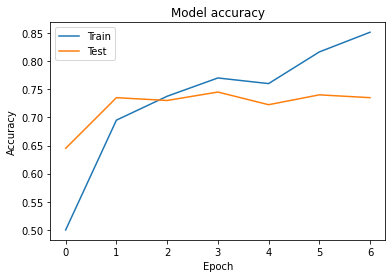

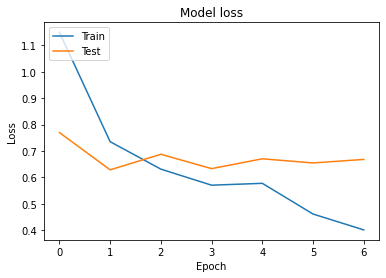

In [ ]:
import matplotlib.pyplot as plt
plt.plot(cnnrnn.model.history.history['accuracy'])
plt.plot(cnnrnn.model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(cnnrnn.model.history.history['loss'])
plt.plot(cnnrnn.model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

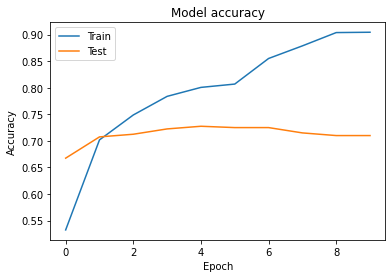

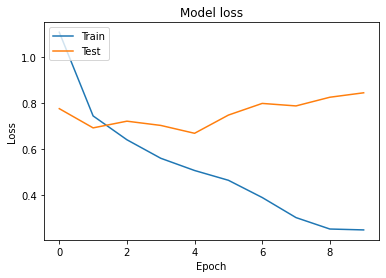

In [ ]:
import matplotlib.pyplot as plt
plt.plot(cnnrnn.model.history.history['accuracy'])
plt.plot(cnnrnn.model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(cnnrnn.model.history.history['loss'])
plt.plot(cnnrnn.model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#@title RNNCNN
from tensorflow.keras.layers import GlobalAveragePooling1D, concatenate
class RNNCNN(KerasBaseModel):
    def __init__(self, config, **kwargs):
        super(RNNCNN, self).__init__(config, **kwargs)

    def build(self):
        input_text = Input(shape=(self.max_len,))

        embedding_layer = Embedding(self.word_embeddings.shape[0], self.word_embeddings.shape[1],
                                    weights=[self.word_embeddings],
                                    trainable=self.config.word_embed_trainable)(input_text)
        text_embed = SpatialDropout1D(0.4)(embedding_layer)

        gru_layer = Bidirectional(GRU(self.config.rnn_units, return_sequences=True))(text_embed)

        conv_layer = Conv1D(64, kernel_size=2, padding="valid", kernel_initializer="he_uniform")(gru_layer)

        avg_pool = GlobalAveragePooling1D()(conv_layer)
        max_pool = GlobalMaxPooling1D()(conv_layer)
        sentence_embed = concatenate([avg_pool, max_pool])

        dense_layer = Dense(256, activation='relu')(sentence_embed)
        output = Dense(self.n_class, activation='softmax')(dense_layer)

        model = Model(input_text, output)
        model.compile(loss='categorical_crossentropy', metrics=(['accuracy',precision,recall,f1]), optimizer=self.config.optimizer)
        return model

config.checkpoint_dir = "/content/RNNCNN/cp.ckpt"
rnncnn = RNNCNN(config)

In [ ]:
rnncnn.train(data_train = (X_train,y_train),data_dev=(X_test,y_test))

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1472/1600 [==========================>...] - ETA: 0s - loss: 1.0031 - acc: 0.5720
Epoch 00001: val_loss improved from inf to 0.66227, saving model to /content/RNNCNN/cp.ckpt
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.9866 - acc: 0.5794 - val_loss: 0.6623 - val_acc: 0.7550
Epoch 2/10
1472/1600 [==========================>...] - ETA: 0s - loss: 0.6920 - acc: 0.7167
Epoch 00002: val_loss improved from 0.66227 to 0.57616, saving model to /content/RNNCNN/cp.ckpt
1600/1600 [==============================] - 1s 678us/sample - loss: 0.6821 - acc: 0.7200 - val_loss: 0.5762 - val_acc: 0.7550
Epoch 3/10
1472/1600 [==========================>...] - ETA: 0s - loss: 0.5489 - acc: 0.7833
Epoch 00003: val_loss did not improve from 0.57616
1600/1600 [==============================] - 1s 634us/sample - loss: 0.5493 - acc: 0.7825 - val_loss: 0.5819 - val_acc: 0.7775
Epoch 4/10
1472/1600 [==========================>...] - 

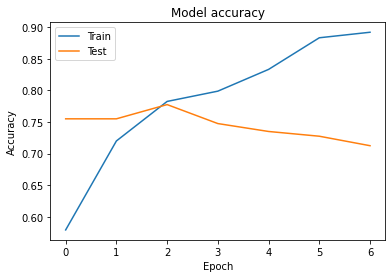

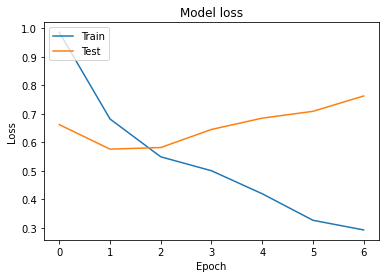

In [ ]:
plt.plot(rnncnn.model.history.history['accuracy'])
plt.plot(rnncnn.model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(rnncnn.model.history.history['loss'])
plt.plot(rnncnn.model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#@title VDCNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, BatchNormalization, Activation, Add, MaxPooling1D, Dense, Flatten
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import Flatten, Layer, InputSpec
import tensorflow as tf

class KMaxPooling(Layer):
    """
    Implemetation of temporal k-max pooling layer, which was first proposed in Kalchbrenner et al.
    [http://www.aclweb.org/anthology/P14-1062]
    "A Convolutional Neural Network for Modelling Sentences"
    This layer allows to detect the k most important features in a sentence, independent of their
    specific position, preserving their relative order.
    """
    def __init__(self, k=1, sorted=True, **kwargs):
        super().__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)
        self.k = k
        self.sorted = sorted

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.k, input_shape[2])

    def call(self, inputs):
        # swap last two dimensions since top_k will be applied along the last dimension
        shifted_inputs = tf.transpose(inputs, [0, 2, 1])
        
        # extract top_k, returns two tensors [values, indices]
        top_k = tf.nn.top_k(shifted_inputs, k=self.k, sorted=self.sorted)[0]
        
        # return flattened output
        return tf.transpose(top_k, [0,2,1])

def identity_block(inputs, filters, kernel_size=3, use_bias=False, shortcut=False):
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(inputs)
    bn1 = BatchNormalization()(conv1)
    relu = Activation('relu')(bn1)
    conv2 = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(relu)
    out = BatchNormalization()(conv2)
    if shortcut:
        out = Add()([out, inputs])
    return Activation('relu')(out)

def conv_block(inputs, filters, kernel_size=3, use_bias=False, shortcut=False, 
               pool_type='max', sorted=True, stage=1):
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(inputs)
    bn1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(bn1)

    conv2 = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(relu1)
    out = BatchNormalization()(conv2)

    if shortcut:
        residual = Conv1D(filters=filters, kernel_size=1, strides=2, name='shortcut_conv1d_%d' % stage)(inputs)
        residual = BatchNormalization(name='shortcut_batch_normalization_%d' % stage)(residual)
        out = downsample(out, pool_type=pool_type, sorted=sorted, stage=stage)
        out = Add()([out, residual])
        out = Activation('relu')(out)
    else:
        out = Activation('relu')(out)
        out = downsample(out, pool_type=pool_type, sorted=sorted, stage=stage)
    if pool_type is not None:
        out = Conv1D(filters=2*filters, kernel_size=1, strides=1, padding='same', name='1_1_conv_%d' % stage)(out)
        out = BatchNormalization(name='1_1_batch_normalization_%d' % stage)(out)
    return out

def downsample(inputs, pool_type='max', sorted=True, stage=1):
    if pool_type == 'max':
        out = MaxPooling1D(pool_size=3, strides=2, padding='same', name='pool_%d' % stage)(inputs)
    elif pool_type == 'k_max':
        k = int(inputs._keras_shape[1]/2)
        out = KMaxPooling(k=k, sorted=sorted, name='pool_%d' % stage)(inputs)
    elif pool_type == 'conv':
        out = Conv1D(filters=inputs._keras_shape[-1], kernel_size=3, strides=2, padding='same', name='pool_%d' % stage)(inputs)
        out = BatchNormalization()(out)
    elif pool_type is None:
        out = inputs
    else:
        raise ValueError('unsupported pooling type!')
    return out

def VDCNN(num_classes=4, depth=9, sequence_length=128, embedding_dim=300, 
          shortcut=False, pool_type='max', sorted=True, use_bias=False, input_tensor=None):
    if depth == 9:
        num_conv_blocks = (1, 1, 1, 1)
    elif depth == 17:
        num_conv_blocks = (2, 2, 2, 2)
    elif depth == 29:
        num_conv_blocks = (5, 5, 2, 2)
    elif depth == 49:
        num_conv_blocks = (8, 8, 5, 3)
    else:
        raise ValueError('unsupported depth for VDCNN.')
  
    inputs = Input(shape=(sequence_length, ), name='inputs')
    embedded_chars = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)(inputs)
    out = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', name='temp_conv')(embedded_chars)

    # Convolutional Block 64
    for _ in range(num_conv_blocks[0] - 1):
        out = identity_block(out, filters=64, kernel_size=3, use_bias=use_bias, shortcut=shortcut)
    out = conv_block(out, filters=64, kernel_size=3, use_bias=use_bias, shortcut=shortcut, 
                     pool_type=pool_type, sorted=sorted, stage=1)

    # Convolutional Block 128
    for _ in range(num_conv_blocks[1] - 1):
        out = identity_block(out, filters=128, kernel_size=3, use_bias=use_bias, shortcut=shortcut)
    out = conv_block(out, filters=128, kernel_size=3, use_bias=use_bias, shortcut=shortcut, 
                     pool_type=pool_type, sorted=sorted, stage=2)

    # Convolutional Block 256
    for _ in range(num_conv_blocks[2] - 1):
        out = identity_block(out, filters=256, kernel_size=3, use_bias=use_bias, shortcut=shortcut)
    out = conv_block(out, filters=256, kernel_size=3, use_bias=use_bias, shortcut=shortcut, 
                     pool_type=pool_type, sorted=sorted, stage=3)

    # Convolutional Block 512
    for _ in range(num_conv_blocks[3] - 1):
        out = identity_block(out, filters=512, kernel_size=3, use_bias=use_bias, shortcut=shortcut)
    out = conv_block(out, filters=512, kernel_size=3, use_bias=use_bias, shortcut=False, 
                     pool_type=None, stage=4)

    # k-max pooling with k = 8
    out = KMaxPooling(k=8, sorted=True)(out)
    out = Flatten()(out)

    # Dense Layers
    out = Dense(2048, activation='relu')(out)
    out = Dense(2048, activation='relu')(out)
    out = Dense(num_classes, activation='softmax')(out)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = inputs

    # Create model.
    model = Model(inputs=inputs, outputs=out, name='VDCNN')
    return model


In [ ]:
model = VDCNN()
model.compile(Adam(lr=1e-4), loss='categorical_crossentropy',metrics=(['accuracy',precision,recall,f1]))
model.fit(X_train,y_train, batch_size=128, epochs=10,
                       validation_data=(X_test,y_test))

Epoch 1/10
13/13 [==============================] - 2s 155ms/step - loss: 1.7715 - accuracy: 0.3750 - precision: 0.4166 - recall: 0.2362 - f1: 0.2820 - val_loss: 1.3671 - val_accuracy: 0.3850 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: nan
Epoch 2/10
13/13 [==============================] - 2s 119ms/step - loss: 1.0106 - accuracy: 0.5725 - precision: 0.7012 - recall: 0.3660 - f1: 0.4704 - val_loss: 1.3450 - val_accuracy: 0.3850 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: nan
Epoch 3/10
13/13 [==============================] - 2s 120ms/step - loss: 0.7459 - accuracy: 0.7094 - precision: 0.7850 - recall: 0.5817 - f1: 0.6672 - val_loss: 1.3407 - val_accuracy: 0.3850 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: nan
Epoch 4/10
13/13 [==============================] - 2s 119ms/step - loss: 0.5073 - accuracy: 0.8356 - precision: 0.8799 - recall: 0.7614 - f1: 0.8163 - val_loss: 1.3520 - val_accuracy: 0.3850 - val_precision: 0.0000e+00 - v

In [ ]:
model = VDCNN()
model.compile(Adam(lr=1e-4), loss='categorical_crossentropy',metrics=(['accuracy',precision,recall,f1]))
model.fit(X_train,y_train, batch_size=6, epochs=30,
                       validation_data=(X_test,y_test))

Epoch 1/30
267/267 [==============================] - 6s 23ms/step - loss: 1.3943 - accuracy: 0.4231 - precision: 0.4655 - recall: 0.2694 - f1: nan - val_loss: 1.3786 - val_accuracy: 0.3875 - val_precision: 0.4085 - val_recall: 0.3831 - val_f1: nan
Epoch 2/30
267/267 [==============================] - 6s 21ms/step - loss: 0.9855 - accuracy: 0.5869 - precision: 0.6648 - recall: 0.4710 - f1: nan - val_loss: 0.9037 - val_accuracy: 0.6400 - val_precision: 0.6908 - val_recall: 0.5547 - val_f1: nan
Epoch 3/30
267/267 [==============================] - 5s 21ms/step - loss: 0.8384 - accuracy: 0.6456 - precision: 0.7141 - recall: 0.5646 - f1: nan - val_loss: 0.9224 - val_accuracy: 0.6325 - val_precision: 0.6746 - val_recall: 0.5647 - val_f1: nan
Epoch 4/30
267/267 [==============================] - 5s 20ms/step - loss: 0.7119 - accuracy: 0.7150 - precision: 0.7624 - recall: 0.6442 - f1: nan - val_loss: 1.1257 - val_accuracy: 0.5625 - val_precision: 0.5774 - val_recall: 0.5249 - val_f1: 0.5473
E

In [ ]:
model.history.history['val_accuracy']

TypeError: ignored

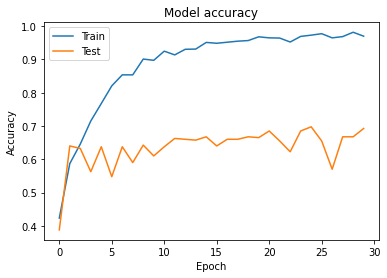

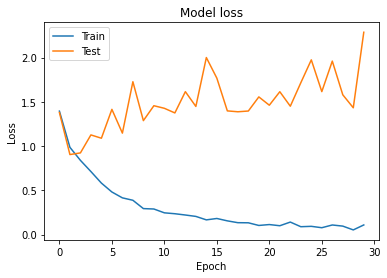

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#@title DCNN
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *


class Folding(Layer):
    def __init__(self, **kwargs):
        super(Folding, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError('Input into Folding Layer must be a 3D tensor!')
        super(Folding, self).build(input_shape)

    def call(self, inputs):
        # split the tensor along dimension 2 into dimension_axis_size/2
        # which will give us 2 tensors.
        # will raise ValueError if K.int_shape(inputs) is odd
        splits = tf.split(inputs, int(K.int_shape(inputs)[-1] / 2), axis=-1)

        # reduce sums of the pair of rows we have split onto
        reduce_sums = [tf.reduce_sum(split, axis=-1) for split in splits]

        # stack them up along the same axis we have reduced
        row_reduced = tf.stack(reduce_sums, axis=-1)
        return row_reduced

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], int(input_shape[2] / 2)

class DCNN(KerasBaseModel):
    def __init__(self, config, **kwargs):
        super(DCNN, self).__init__(config, **kwargs)

    def build(self):
        input_text = Input(shape=(self.max_len,))

        embedding_layer = Embedding(self.word_embeddings.shape[0], self.word_embeddings.shape[1],
                                    weights=[self.word_embeddings],
                                    trainable=self.config.word_embed_trainable)(input_text)
        text_embed = SpatialDropout1D(0.2)(embedding_layer)

        # wide convolution
        zero_padded_1 = ZeroPadding1D((6, 6))(text_embed)
        conv_1 = Conv1D(filters=128, kernel_size=7, strides=1, padding='valid')(zero_padded_1)
        # dynamic k-max pooling
        k_maxpool_1 = KMaxPooling(int(self.max_len / 3 * 2))(conv_1)
        # non-linear feature function
        non_linear_1 = ReLU()(k_maxpool_1)

        # wide convolution
        zero_padded_2 = ZeroPadding1D((4, 4))(non_linear_1)
        conv_2 = Conv1D(filters=128, kernel_size=5, strides=1, padding='valid')(zero_padded_2)
        # dynamic k-max pooling
        k_maxpool_2 = KMaxPooling(int(self.max_len / 3 * 1))(conv_2)
        # non-linear feature function
        non_linear_2 = ReLU()(k_maxpool_2)

        # wide convolution
        zero_padded_3 = ZeroPadding1D((2, 2))(non_linear_2)
        conv_3 = Conv1D(filters=128, kernel_size=5, strides=1, padding='valid')(zero_padded_3)
        # folding
        folded = Folding()(conv_3)
        # dynamic k-max pooling
        k_maxpool_3 = KMaxPooling(k=10)(folded)
        # non-linear feature function
        non_linear_3 = ReLU()(k_maxpool_3)

        sentence_embed = Flatten()(non_linear_3)

        dense_layer = Dense(256, activation='relu')(sentence_embed)
        output = Dense(self.n_class, activation='softmax')(dense_layer)

        model = Model(input_text, output)
        model.compile(loss='categorical_crossentropy', metrics=(['accuracy',precision,recall,f1]), optimizer=self.config.optimizer)
        return model

In [ ]:
config = Config()
config.word_embeddings = embedding_matrix
config.checkpoint_dir = "/content/DCNN/cp.ckpt"
config.batch_size = 64
dcnn = DCNN(config)
dcnn.train(data_train = (X_train,y_train),data_dev=(X_test,y_test))

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.1583 - accuracy: 0.4888 - precision: 0.4427 - recall: 0.2175 - f1: nan
Epoch 00001: val_loss improved from inf to 0.88670, saving model to /content/DCNN/cp.ckpt
25/25 [==============================] - 2s 70ms/step - loss: 1.1583 - accuracy: 0.4888 - precision: 0.4427 - recall: 0.2175 - f1: nan - val_loss: 0.8867 - val_accuracy: 0.5975 - val_precision: 0.6520 - val_recall: 0.4196 - val_f1: 0.5103
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.7770 - accuracy: 0.6844 - precision: 0.7413 - recall: 0.5719 - f1: 0.6435
Epoch 00002: val_loss improved from 0.88670 to 0.73609, saving model to /content/DCNN/cp.ckpt
25/25 [==============================] - 1s 45ms/step - loss: 0.7770 - accuracy: 0.6844 - precision: 0.7413 - recall: 0.5719 - f1: 0.6435 - val_loss: 0.7361 - val_accuracy: 0.6925 - val_precision: 0.7240 - val_recall: 0.6317 - val_f1: 0.6740
Epoch 3/10
25/25 [==============================] 

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
config = Config()
config.word_embeddings = embedding_matrix
config.checkpoint_dir = "/content/DCNN/cp.ckpt"
config.batch_size = 64
dcnn = DCNN(config)
dcnn.train(data_train = (X_train,y_train),data_dev=(X_test,y_test))

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.1437 - acc: 0.4844
Epoch 00001: val_loss improved from inf to 0.86055, saving model to /content/DCNN/cp.ckpt
25/25 [==============================] - 2s 96ms/step - loss: 1.1437 - acc: 0.4844 - val_loss: 0.8605 - val_acc: 0.6425
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.7669 - acc: 0.6975
Epoch 00002: val_loss improved from 0.86055 to 0.84435, saving model to /content/DCNN/cp.ckpt
25/25 [==============================] - 2s 83ms/step - loss: 0.7669 - acc: 0.6975 - val_loss: 0.8443 - val_acc: 0.6750
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.6444 - acc: 0.7606
Epoch 00003: val_loss improved from 0.84435 to 0.70003, saving model to /content/DCNN/cp.ckpt
25/25 [==============================] - 2s 84ms/step - loss: 0.6444 - acc: 0.7606 - val_loss: 0.7000 - val_acc: 0.7275
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.5363 - acc: 0.7950
Epoch 

In [ ]:
!pip install sacrebleu -q
!pip install fastBPE -q
!pip install fairseq -q
!pip install transformers -q

     |████████████████████████████████| 71kB 2.8MB/s 
     |████████████████████████████████| 307kB 4.6MB/s 
     |████████████████████████████████| 1.1MB 4.4MB/s 
     |████████████████████████████████| 890kB 12.6MB/s 
     |████████████████████████████████| 1.1MB 22.9MB/s 
     |████████████████████████████████| 3.0MB 41.7MB/s 


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import TFBertModel,BertTokenizer
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#@title BERT (Without Fine Tuning)
bert_layer = TFBertModel.from_pretrained('bert-large-cased')
bert_layer.trainable = False
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')

Some weights of the model checkpoint at bert-large-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-large-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data['Primary'].values)
data['bert_target'] = le.transform(data['Primary'])

In [ ]:
data['bert_target']

0       0
1       0
2       0
3       0
4       0
       ..
1995    1
1996    1
1997    1
1998    1
1999    1
Name: bert_target, Length: 2000, dtype: int64

In [ ]:
def encode(texts):
    input_id = []
    # token_type_id = []
    attention_mask = []
    for text in texts:
      dictIn = tokenizer.encode_plus(text,max_length=60,pad_to_max_length=True,truncation=True)
      input_id.append(dictIn['input_ids'])
      # token_type_id.append(dictIn['token_type_ids'])
      attention_mask.append(dictIn['attention_mask'])
    # return np.array(input_id), np.array(token_type_id),np.array(attention_mask)
    return np.array(input_id),np.array(attention_mask)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(data['clean_text'].values,data['bert_target'].values, test_size=0.2,shuffle=True,random_state=124, stratify=data['bert_target'])
X_train = encode(X_train)
X_test = encode(X_test)
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
y_train

array([2, 0, 0, ..., 2, 1, 0])

In [ ]:
input_word_ids = Input(shape=(60,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(60,), dtype=tf.int32, name="input_mask")
# segment_ids = Input(shape=(128,), dtype=tf.int32, name="segment_ids")

_, output = bert_layer([input_word_ids, input_mask])
output = Dense(32,activation='relu')(output)
output = Dropout(0.2)(output)
# out = SpatialDropout1D(0.4)(sequence_output)
# out = Dense(200, activation='sigmoid')(out)
out1 = Dense(1,activation='sigmoid')(output)
bert_model = Model(inputs=[input_word_ids, input_mask], outputs=out1)
bert_model.compile(Adam(lr=6e-5), loss='binary_crossentropy', metrics=['accuracy'])
model_ckpt = ModelCheckpoint(
            filepath="/content/BERT/cp.ckpt",
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            verbose = 1)
early_stop = EarlyStopping(
            monitor='loss',
            mode='max',
            patience=20,
            verbose = 1
        )
lr_callback = CyclicLR()

In [ ]:
history = bert_model.fit(X_train,y_train, batch_size=10, epochs=3,
                       validation_data=(X_test,y_test), callbacks=[model_ckpt,early_stop,lr_callback])

Epoch 1/3
  2/160 [..............................] - ETA: 13s - loss: -0.2115 - accuracy: 0.2500WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0524s vs `on_train_batch_end` time: 0.1206s). Check your callbacks.


160/160 [==============================] - ETA: 0s - loss: -12.1380 - accuracy: 0.2362WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0307s vs `on_test_batch_end` time: 0.1241s). Check your callbacks.



Epoch 00001: val_loss improved from inf to -32.79806, saving model to /content/BERT/cp.ckpt
160/160 [==============================] - 40s 248ms/step - loss: -12.1380 - accuracy: 0.2362 - val_loss: -32.7981 - val_accuracy: 0.2325
Epoch 2/3
160/160 [==============================] - ETA: 0s - loss: -64.6843 - accuracy: 0.2338
Epoch 00002: val_loss improved from -32.79806 to -127.35713, saving model to /content/BERT/cp.ckpt
160/160 [==============================] - 38s 240ms/step - loss: -64.6843 - accuracy: 0.2338 - val_loss: -127.3571 - val_accuracy: 0.2325
Epoch 3/3
160/160 [==============================] - ETA: 0s - loss: -230.4436 - accuracy: 0.2350
Epoch 00003: val_loss improved from -127.35713 to -399.16196, saving model to /content/BERT/cp.ckpt
160/160 [==============================] - 40s 247ms/step - loss: -230.4436 - accuracy: 0.2350 - val_loss: -399.1620 - val_accuracy: 0.2325
